In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import os
# MODEL
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import regularizers
#for encoding data
from keras.utils import to_categorical



from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import RepeatVector

Using TensorFlow backend.


In [0]:
import data_generator

train_examples = 50000
test_examples=5000

train_generator = data_generator.training_generator(batch_size=train_examples)
test_generator = data_generator.test_generator(batch_size = test_examples)

x_train, x_labels, numbers_sum = next(train_generator)
y_test, y_labels, y_numbers_sum = next(test_generator)

# x.shape == (8, 2, 28, 84)     # 8 pairs of images with height 28px and width 84px
# numbers.shape == (8, 2)       # 8 pairs of numbers corresponding to the images
# numbers_sum.shape == (8, 1)   # 8 numbers that represent the sum of the numbers from the images

x_train, y_test = x_train / 255.0, y_test / 255.0 # scaling the data



In [3]:
numbers_sum[0]
print(len(x_train))

50000


For the end to end network I chose to concatenate the images one on top of the other, to encode the vector of digits obtained from the label into a binary matrix representation representation.

Next, the 2 models fom part 1 and part 2 have been combined. 

Below the 2 concaten

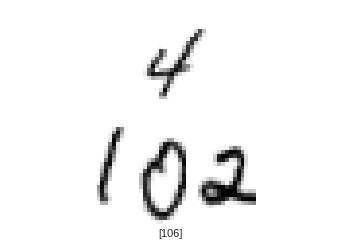

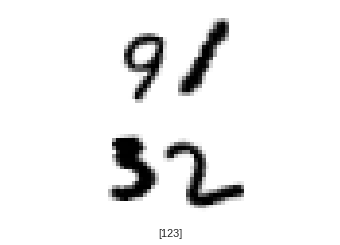

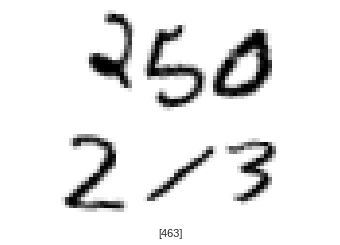

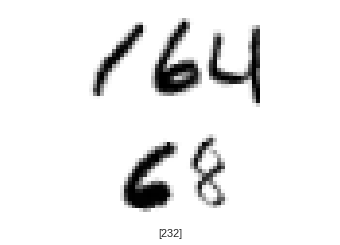

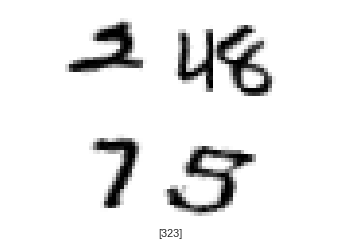

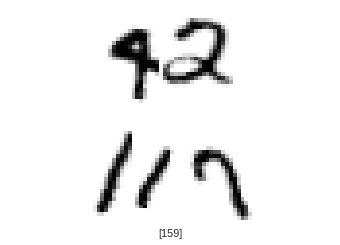

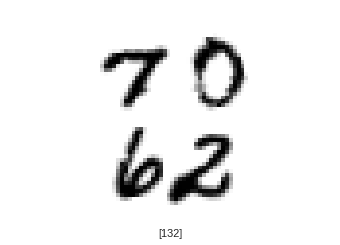

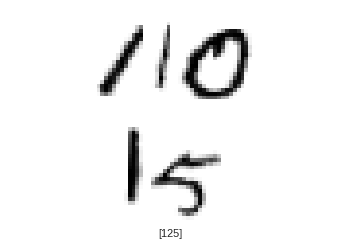

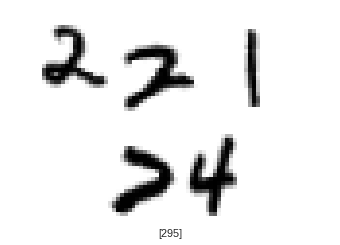

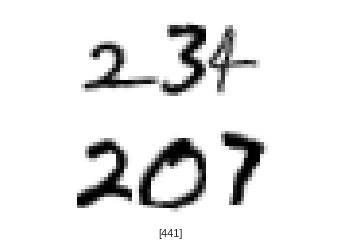

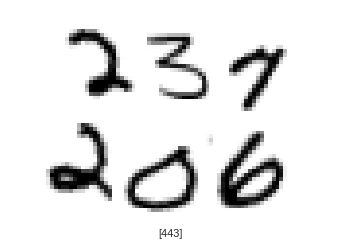

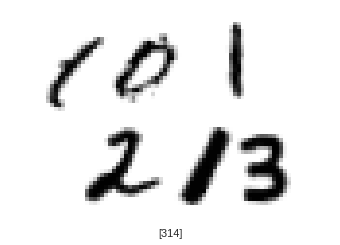

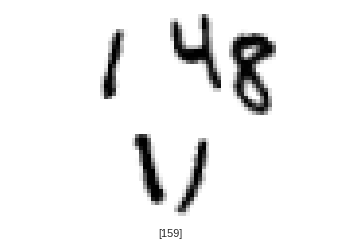

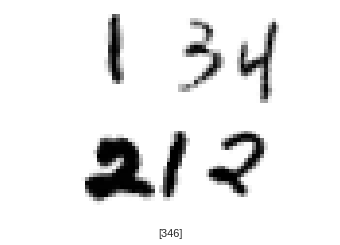

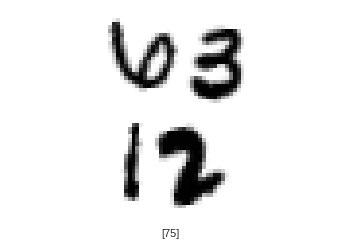

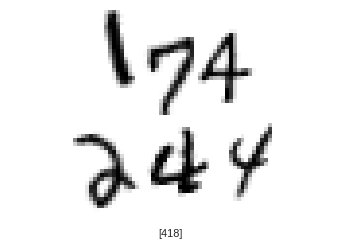

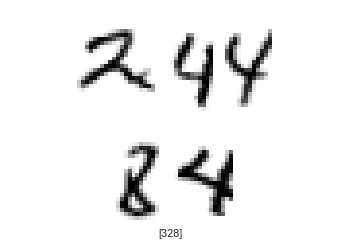

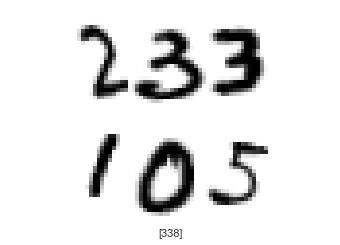

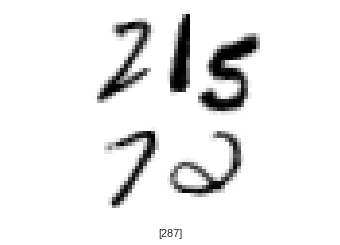

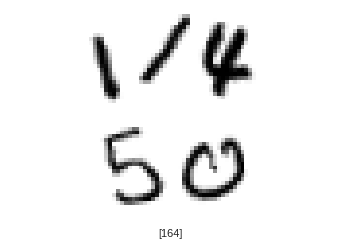

In [4]:
new_input =[]
for i in range(train_examples):
  new_input.append(np.concatenate((x_train[i][0],x_train[i][1]),axis=0))
  
  
new_test =[]
for i in range(test_examples):
  new_test.append(np.concatenate((y_test[i][0],y_test[i][1]),axis=0))

  
#plot them to be sure they are correct  
for i in range(20):
  plt.figure()
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(new_test[i], cmap=plt.cm.binary)
  plt.xlabel(y_numbers_sum[i])
  
  


In [5]:
new_input = np.array(new_input)
new_test = np.array(new_test)
new_input.shape[1:]


(56, 84)

In [6]:

def encode(data):
    print('Shape of data (BEFORE encode): %s' % str(data.shape))
    encoded = to_categorical(data)
    print('Shape of data (AFTER  encode): %s\n' % str(encoded.shape))
    return encoded


def decode(datum):
    return np.argmax(datum)

#encode label
number_sum_str = np.array([str(x[0]) for x in numbers_sum])
sums = np.array([[x.rjust(3,'0')] for x in number_sum_str])



number_sum_str_test = np.array([str(x[0]) for x in y_numbers_sum])
sums_test = np.array([[x.rjust(3,'0')] for x in number_sum_str_test])

digits_sums = np.array([[int(d) for d in x[0]] for x in sums])
digits_sums_test = np.array([[int(d) for d in x[0]] for x in sums_test])

encoded_labels = encode(digits_sums)
encoded_labels_test = encode(digits_sums_test)


Shape of data (BEFORE encode): (50000, 3)
Shape of data (AFTER  encode): (50000, 3, 10)

Shape of data (BEFORE encode): (5000, 3)
Shape of data (AFTER  encode): (5000, 3, 10)



In [0]:

new_input = new_input.reshape(train_examples,56,84,1)
new_test = new_test.reshape(test_examples,56,84,1)

In [0]:
# for layer in model.layers:
#   print(layer.get_output_at(0).get_shape().as_list())

The initial input shape received by the model is of(train_examples,56,84,1).

After the Flatten layer, I reshaped the input to (1,-1), in order to hardcode for the LSTM input shape.

The model was initially overfitting so I added a Dropout layer.

In [9]:

# MODEL


from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense,Reshape

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=new_input.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# the model so far outputs 3D feature maps (height, width, features)

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Reshape((1,-1)))

# model = Sequential()
model.add(LSTM(100,input_shape=(1,-1)))
model.add(RepeatVector(3))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(10,activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 54, 82, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 54, 82, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 41, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 39, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 25, 39, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 19, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 19, 32)        0         
__________

In [10]:
history = model.fit(new_input, encoded_labels,
          validation_data = (new_test, encoded_labels_test),
          batch_size = 64,
          epochs=100)
#model.fit(new_input,encoded_labels,epochs=100, batch_size=64)

Train on 50000 samples, validate on 5000 samples
Epoch 1/100
50000/50000 [==============================] - 32s 647us/step - loss: 1.9190 - acc: 0.2416 - val_loss: 1.8076 - val_acc: 0.2745
Epoch 2/100
50000/50000 [==============================] - 27s 542us/step - loss: 1.7757 - acc: 0.2965 - val_loss: 1.7167 - val_acc: 0.3257
Epoch 3/100
50000/50000 [==============================] - 27s 540us/step - loss: 1.7212 - acc: 0.3243 - val_loss: 1.6678 - val_acc: 0.3482
Epoch 4/100
50000/50000 [==============================] - 27s 540us/step - loss: 1.6737 - acc: 0.3491 - val_loss: 1.6138 - val_acc: 0.3726
Epoch 5/100
50000/50000 [==============================] - 27s 540us/step - loss: 1.6273 - acc: 0.3684 - val_loss: 1.5733 - val_acc: 0.3851
Epoch 6/100
50000/50000 [==============================] - 27s 539us/step - loss: 1.5843 - acc: 0.3864 - val_loss: 1.5362 - val_acc: 0.4064
Epoch 7/100
50000/50000 [==============================] - 27s 538us/step - loss: 1.5440 - acc: 0.4019 - val_lo

## Behaviour of the model

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


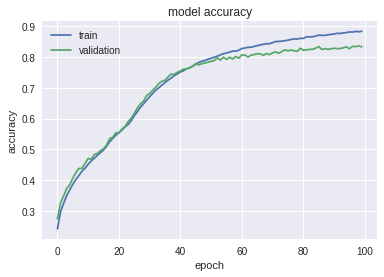

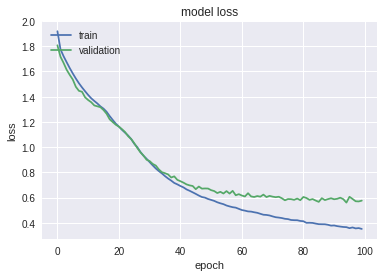

In [11]:
 print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()